# Setting Up Necessary Things

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
bs = 32 # batch size

In [ ]:
!pip install -Uqq fastai fastbook nbdev

In [ ]:
from fastai import *
from fastbook import *
from fastai.vision.all import *
# import* is a way to import all functions, classes, and variables

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/MasterCourse/WasteRecognizer

/content/drive/.shortcut-targets-by-id/1QvrVDCkcfW8Ufghz9ZsuHed6hg981t1m/WasteRecognizer


In [ ]:
waste_labels = ["Plastic waste",
"Metal waste",
"Organic waste",
"Glass waste",
"Electronic waste",
"Textile waste",
"Medical waste",
"Wood waste",
"Paper waste",
"Shoes Waste",
"Cardboard Waste"]
search_queries = {
    "Plastic waste": ["plastic trash", "plastic garbage", "discarded plastic bottles"],
    "Metal waste": ["scrap metal", "rusted metal trash", "discarded aluminum cans"],
    "Organic waste": ["food waste", "rotten fruits and vegetables", "compostable waste"],
    "Glass waste": ["broken glass", "discarded glass bottles", "shattered glass waste"],
    "Electronic waste": ["e-waste", "discarded mobile phones", "old computer parts"],
    "Textile waste": ["old clothes waste", "fabric scraps", "discarded textiles"],
    "Medical waste": ["used syringes waste", "hospital biohazard trash", "medical trash"],
    "Wood waste": ["wood scraps", "broken wooden furniture", "discarded wooden boards"],
    "Paper waste": ["shredded paper trash", "discarded newspapers", "old magazines waste"],
    "Shoes Waste": ["thrown away shoes", "old shoes in garbage", "discarded sneakers"],
    "Cardboard Waste": ["old cardboard boxes", "discarded cartons", "recyclable cardboard"]
}


# Download Images from Browser
using **DuckDuckGo Image Search**

In [ ]:
import os


data_path = "data"
os.makedirs(data_path, exist_ok=True)

for waste_type, queries in search_queries.items():
    dest = os.path.join(data_path, waste_type)
    os.makedirs(dest, exist_ok=True)

    for query in queries:
        try:
            waste_image_urls = search_images_ddg(query, max_images=300)
            download_images(dest, urls=waste_image_urls)
        except :
          continue



In [ ]:
image_counts = get_image_files(data_path)
image_counts

(#5430) [Path('data/Paper waste/eff71694-8eb5-4791-8ecb-1d304a9ce0f5.jpg'),Path('data/Paper waste/a4393b86-f252-4701-97af-990ef547d0f2.jpg'),Path('data/Paper waste/28c029a8-1b21-4f31-b457-30c5c8d6ac61.png'),Path('data/Paper waste/521adab5-5dac-4723-a414-98904f9ae37f.png'),Path('data/Paper waste/f3895bf0-d6ca-4586-9d5b-48cc0dce8c80.png'),Path('data/Paper waste/211b5cc9-eff9-4994-b811-d741a42350e7.jpg'),Path('data/Paper waste/470023ba-e604-4c08-80f0-299cc50d4a8a.jpg'),Path('data/Paper waste/215f5bb3-e6e2-4a0d-9cca-5c66c292e76f.png'),Path('data/Paper waste/4b96b654-4118-4d28-9beb-f736293ad153.jpg'),Path('data/Paper waste/983dac19-7178-425b-84af-8779f8a80408.jpg'),Path('data/Paper waste/4b83349d-d64c-4bab-9ab3-9cf1b74b643c.jpg'),Path('data/Paper waste/cff808b9-8a70-4911-9986-1f014cdeff32.png'),Path('data/Paper waste/5e64efda-5f8e-40b3-82a7-02dd0591fb4c.png'),Path('data/Paper waste/2e62b843-9ca3-4962-b65e-bd904531f373.jpg'),Path('data/Paper waste/f7bf98a4-86df-472d-93b5-fe0adaf34dcf.jpg'),P

In [ ]:
failed = verify_images(image_counts)
failed

In [ ]:
failed.map(Path.unlink)

# From Data to Data Loaders

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,                        # get_image_files returns a list of all images in that path recursively by default
    splitter=RandomSplitter(valid_pct=0.1, seed=42),  # getting 90-10 train-validation split
    get_y=parent_label,                               # taking the folder name as labels
    item_tfms=Resize(128))

In [ ]:
data_path="data"
dls = dblock.dataloaders(data_path,bs=bs)

In [ ]:
dls.train.vocab

['Electronic waste', 'Glass waste', 'Medical waste', 'Metal waste', 'Organic waste', 'Paper waste', 'Plastic waste', 'Shoes Waste', 'Textile waste', 'Wood waste']

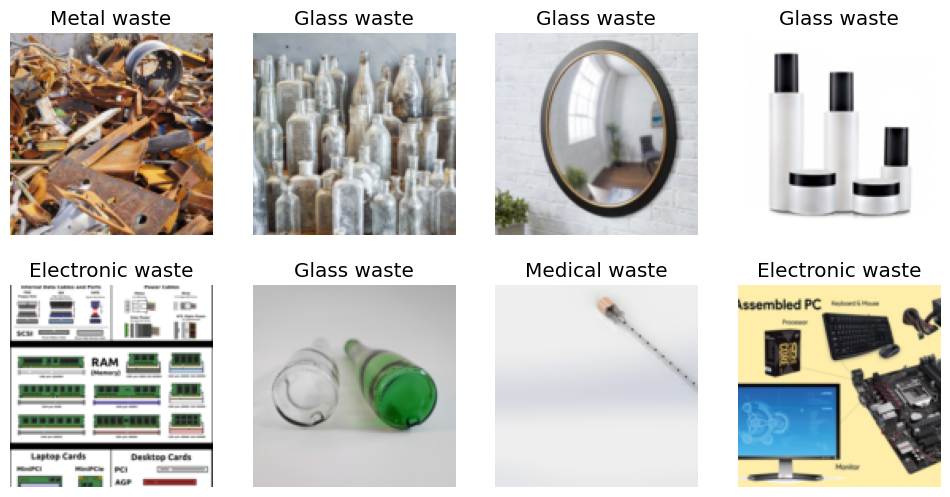

In [ ]:
dls.train.show_batch(max_n=8, nrows=2)

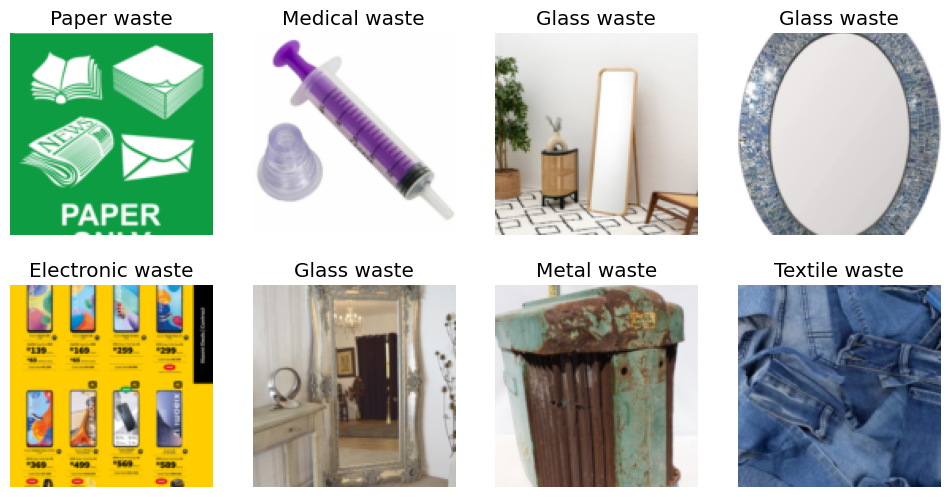

In [ ]:
dls.valid.show_batch(max_n=8, nrows=2)

# Data Augmentation

In [ ]:
dblock = dblock.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms())
dls = dblock.dataloaders(data_path, bs = bs)

# Saving data at Dataloaders

In [ ]:
version=1
torch.save(dls, f"Dataloaders/waste_dataloader_v{version}.pkl")

In [ ]:
version=1
dls = torch.load(f"Dataloaders/waste_dataloader_v{version}.pkl")

<ipython-input-43-24029605aa63>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dls = torch.load(f"Dataloaders/waste_dataloader_v{version}.pkl")


# Training and Data Cleaning

In [ ]:
model_path = "models"

In [ ]:
model = vision_learner(dls, resnet34, metrics=[error_rate,accuracy])

In [ ]:
version=1
model.load(f"waste-recognizer-v{version-1}")

In [ ]:
model.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.299003,0.159227,0.046041,0.953959,29:14


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.491925,0.258303,0.073665,0.926335,03:01


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
model.save(f"waste-recognizer-v{version}")

Path('models/waste-recognizer-v1.pth')

In [ ]:
# model.load(f"waste-recognizer-v{version}")

In [ ]:
interp = ClassificationInterpretation.from_learner(model)
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(2, nrows=3,figsize=(12, 10))

In [ ]:
from fastai.vision.widgets import ImageClassifierCleaner
cleaner = ImageClassifierCleaner(model)
cleaner

In [ ]:
import os
for idx in cleaner.delete():
  print(cleaner.fns[idx])
  cleaner.fns[idx].unlink()                                    # delete irrelevant data
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), f"data/{cat}") # change the directory

# Export model for inference

In [ ]:
model.export(f"{model_path}/waste-recognizer-v{version}.pkl")

In [ ]:
version = 1
img_path = 'test_images'
model_path = f'models/waste-recognizer-v{version}.pkl'

In [ ]:
model = load_learner(model_path)

# Inference 1

**Target:** Plastic waste

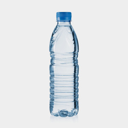

In [ ]:
img = Image.open(f'{img_path}/unknown1.jpg')
img.to_thumb(128,128)

In [ ]:
model.predict(f'{img_path}/unknown1.jpg')

('Plastic waste',
 tensor(6),
 tensor([1.2932e-07, 9.9737e-03, 3.1413e-06, 3.3584e-08, 2.2132e-06, 1.3263e-06, 9.9000e-01, 6.8034e-06, 1.2349e-05, 1.1071e-09]))

# Inference 2

**Target:** Glass waste

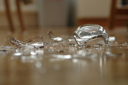

In [ ]:
img = Image.open(f'{img_path}/unknown2.jpg')
img.to_thumb(128,128)

In [ ]:
model.predict(f'{img_path}/unknown2.jpg')

('Glass waste',
 tensor(1),
 tensor([9.1324e-09, 9.9998e-01, 3.9150e-10, 1.5774e-05, 1.0371e-08, 3.0749e-08, 7.0873e-07, 6.4634e-09, 5.3662e-10, 1.2743e-09]))

# Inference 3

**Target:** Textile waste

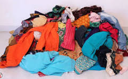

In [ ]:
img = Image.open(f'{img_path}/unknown3.jpeg')
img.to_thumb(128,128)

In [ ]:
model.predict(f'{img_path}/unknown3.jpeg')

('Textile waste',
 tensor(8),
 tensor([3.2702e-05, 1.7089e-05, 4.5034e-04, 9.5420e-06, 1.6814e-04, 2.9450e-04, 9.3613e-05, 6.4559e-04, 9.9822e-01, 7.3127e-05]))

# Inference 4

**Target:** Electronic waste

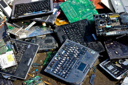

In [ ]:
img = Image.open(f'{img_path}/unknown4.jpg')
img.to_thumb(128,128)

In [ ]:
model.predict(f'{img_path}/unknown4.jpg')

('Electronic waste',
 tensor(0),
 tensor([9.9908e-01, 1.1487e-07, 1.7517e-06, 9.0252e-04, 3.6556e-08, 3.1085e-06, 6.9060e-06, 3.2622e-08, 5.5231e-07, 9.5964e-09]))